# Read data

In [2]:
import pandas as pd

movies = pd.read_csv('data/movies_meta_data.csv', sep=';', engine='python')
users = pd.read_csv('data/users.dat', sep='::', engine='python', names=['userId', 'gender', 'age', 'occupation', 'zip-code'])
ratings = pd.read_csv('data/ratings.dat', sep='::', engine='python', names=['userId', 'movieId', 'rating', 'timestamp'])

<AxesSubplot:title={'center':'Gender distribution'}, ylabel='None'>

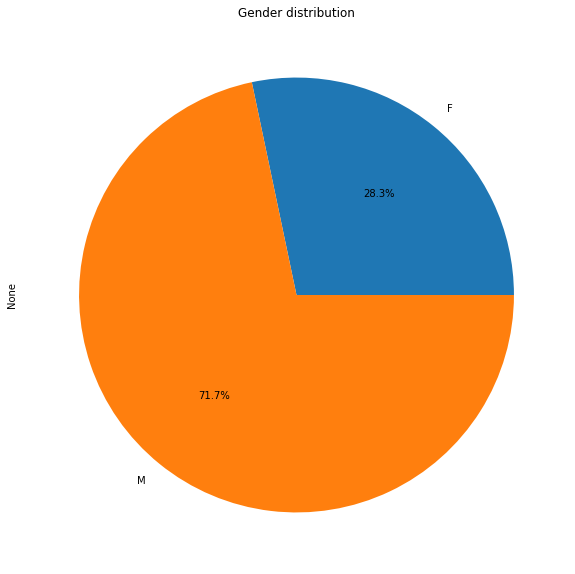

In [3]:
users.groupby('gender').size().plot(kind='pie', y=0, figsize=(10, 10), autopct='%1.1f%%', title='Gender distribution')




In [4]:
ratings.groupby('userId').size()

userId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

<AxesSubplot:title={'center':'Number of ratings per user'}, ylabel='Frequency'>

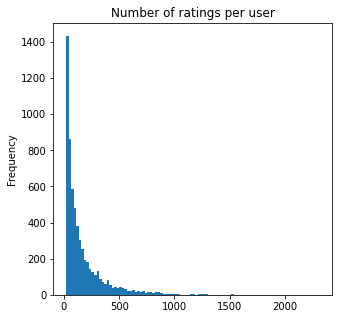

In [5]:
ratings.groupby('userId').size().plot(kind='hist', bins=100, figsize=(5, 5), title='Number of ratings per user', xlabel='Number of ratings', ylabel='Number of users')

# Cleaning

As we don't plan on doing anything with the zip code of the user we will drop this feature.

In [6]:
users_dropped = users.drop(['zip-code'], axis=1)

Because the timestamp adds no value to our model we are going to remove the timestamp from all ratings.

In [7]:
ratings_dropped = ratings.drop('timestamp', axis=1)

In [8]:
movies_dropped = movies[['ml_movieId', 'Title', 'Year', 'Released', 'Runtime', 'Genre', 'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'BoxOffice']]
movies_dropped.head()

,ml_movieId,Title,Year,Released,Runtime,Genre,Ratings,Metascore,imdbRating,imdbVotes,BoxOffice
0,1,Toy Story,1995,22 Nov 1995,81 min,"Animation, Adventure, Comedy","[{'Source': 'Internet Movie Database', 'Value'...",96.0,8.3,"1,009,377","$223,225,679"
1,2,Jumanji,1995,15 Dec 1995,104 min,"Adventure, Comedy, Family","[{'Source': 'Internet Movie Database', 'Value'...",39.0,7.0,"354,984","$100,499,940"
2,3,Grumpier Old Men,1995,22 Dec 1995,101 min,"Comedy, Romance","[{'Source': 'Internet Movie Database', 'Value'...",46.0,6.6,"28,520","$71,518,503"
3,4,Waiting to Exhale,1995,22 Dec 1995,124 min,"Comedy, Drama, Romance","[{'Source': 'Internet Movie Database', 'Value'...",NaN,5.9,"11,434","$67,052,156"
4,5,Father of the Bride Part II,1995,08 Dec 1995,106 min,"Comedy, Family, Romance","[{'Source': 'Internet Movie Database', 'Value'...",49.0,6.0,"39,573","$76,594,107"


In [9]:
import re

# Fill missing 'imdbRating' values with the mean
movies_dropped['imdbRating'].fillna(movies_dropped['imdbRating'].mean(), inplace=True)

# Round the 'imdbRating' values to one decimal place
movies_dropped['imdbRating'] = movies_dropped['imdbRating'].round(decimals=1)

# Convert the 'imdbVotes' column to float type using regular expressions
movies_dropped['imdbVotes'] = movies_dropped['imdbVotes'].apply(lambda x: float(re.sub(r'[^\d.]', '', x)) if isinstance(x, str) else x)

# Fill in missing values with mean
movies_dropped['imdbVotes'].fillna(movies_dropped['imdbVotes'].mean(), inplace=True)

# Round the 'imdbVotes' values to zero decimal places
movies_dropped['imdbVotes'] = movies_dropped['imdbVotes'].round(decimals=0)

# Convert the 'BoxOffice' column to float type using regular expressions
movies_dropped['BoxOffice'] = movies_dropped['BoxOffice'].apply(lambda x: float(re.sub(r'[^\d.]', '', x)) if isinstance(x, str) else x)

# Fill in missing values with mean
movies_dropped['BoxOffice'].fillna(movies_dropped['BoxOffice'].mean(), inplace=True)

# Round the 'BoxOffice' values to zero decimal places
movies_dropped['BoxOffice'] = movies_dropped['BoxOffice'].round(decimals=0)

# Convert the 'Runtime' column from minutes to hours
movies_dropped['Runtime'] = movies_dropped['Runtime'].apply(lambda x: int(re.sub(r'\D', '', x)) / 60 if isinstance(x, str) else x)

# Fill in missing values with mean
movies_dropped['Runtime'].fillna(movies_dropped['Runtime'].mean(), inplace=True)

C:\Users\Fabio\AppData\Local\Temp\ipykernel_8832\2342669516.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Fabio\AppData\Local\Temp\ipykernel_8832\2342669516.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Fabio\AppData\Local\Temp\ipykernel_8832\2342669516.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [10]:
# Drop rows with missing values by selecting only rows without NaN values in the 'Released' column
movies_dropped = movies_dropped.loc[~pd.isna(movies_dropped['Released'])]
movies_dropped['Released'].isna().sum()

0

In [11]:
# Drop the rows with missing values in the 'Genre' column
movies_dropped.dropna(subset=['Genre'], inplace=True)
movies_dropped['Genre'].isna().sum()

C:\Users\Fabio\AppData\Local\Temp\ipykernel_8832\1300742977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0

# Transformation

In [12]:
# Define a dictionary to map numeric occupation values to text labels
occupation_labels = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer",
}

# Replace the numeric occupation values with text labels using the map method
users_dropped["occupation"] = users["occupation"].map(occupation_labels)

In [13]:
age_labels = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+",
}

# Replace the numeric age values with text labels using the map method
users_dropped["age"] = users["age"].map(age_labels)

In [14]:
users_dropped.head()

,userId,gender,age,occupation
0,1,F,Under 18,K-12 student
1,2,M,56+,self-employed
2,3,M,25-34,scientist
3,4,M,45-49,executive/managerial
4,5,M,25-34,writer


# Merge

In [15]:
# Rename the 'ml_movieId' column to 'movieId'
movies_dropped.rename(columns={'ml_movieId': 'movieId'}, inplace=True)

C:\Users\Fabio\AppData\Local\Temp\ipykernel_8832\971521124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
merged = movies_dropped.merge(ratings_dropped, on='movieId', how='left')
# merged['userId'] = merged['userId'].astype('int32')
merged.isna().sum()
# merged.head()

movieId           0
Title             0
Year              0
Released          0
Runtime           0
Genre             0
Ratings           0
Metascore     75054
imdbRating        0
imdbVotes         0
BoxOffice         0
userId          117
rating          117
dtype: int64

In [17]:
merged.shape

(935989, 13)

# SVD approach with Surprise

In [18]:
from surprise import Reader, Dataset, SVD, accuracy, KNNBasic
from surprise.model_selection import train_test_split

model = SVD()
data = Dataset.load_from_df(ratings_dropped, Reader(rating_scale=(1, 5)))
trainset, testset = train_test_split(data, test_size=.25)

model.fit(trainset)
predictions = model.test(testset)

accuracy.rmse(predictions)

ModuleNotFoundError: No module named 'surprise'

### Exporting the model

In [ ]:
from surprise import dump

# Dump algorithm and reload it.
file_name = 'models/SVD_Model'
dump.dump(file_name, algo=model)
_, loaded_algo = dump.load(file_name)

FileNotFoundError: [Errno 2] No such file or directory: '/models/SVD_Model'

### Handling a new user

In [ ]:

new_user_id = 9999
new_user_movies = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
new_user_ratings = [5, 4, 3, 2, 1, 5, 4, 3, 2, 1]

new_user = pd.DataFrame({'userId': new_user_id, 'movieId': new_user_movies, 'rating': new_user_ratings})
ratings_combined = pd.concat([ratings_dropped, new_user], ignore_index=True)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_combined, reader)

# Retrain the model with the combined ratings data
model = SVD()
trainset = data.build_full_trainset()
model.fit(trainset)

model.predict(uid=new_user_id, iid=3)


# Recommendation with pearson similarity matrix

In [ ]:
pivot = merged.pivot_table(index=['userId'], columns=['Title'], values='rating')
pivot.head()

In [ ]:
pivot = pivot.dropna(thresh=10, axis=1).fillna(0)
pivot.head()

In [ ]:
similarity_df = pivot.corr(method='pearson')
similarity_df.head()
similarity_df.to_csv('data/similarity.csv')

In [ ]:
def get_similar_movies(title, user_rating):
    similar_score = similarity_df[title]*(user_rating-2.5)
    similar_score = similar_score.sort_values(ascending=False)
    
    return similar_score

In [ ]:
action_lover = [("Jurassic Park", 5), ("The Lost World: Jurassic Park", 5), ('Titanic', 3), ('Forrest Gump', 5)]
similar_movies = pd.DataFrame()

for movie, rating in action_lover:
    similar_movies = similar_movies.append(get_similar_movies(movie, rating), ignore_index=True)

similar_movies.head()
similar_movies.sum().sort_values(ascending=False).head(20)

In [ ]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

explainer = ClassifierExplainer(model, testset, labels=['1', '2', '3', '4', '5'])

db = ExplainerDashboard(explainer, title="Movie Recommender")
db.run(port=8050)

C:\Users\Fabio\AppData\Roaming\Python\Python310\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\Fabio\AppData\Roaming\Python\Python310\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizat

NameError: name 'model' is not defined